# Functions

In [1]:
import pandas as pd
import numpy as np
import random

In [2]:
_df = pd.read_csv("sampleTableV2.csv") # read csv file as dataframe

In [3]:
_df.head()

,pub_id,first_name,last_name,aff_country,aff_country_code,aff_id,aff_city,aff_city_id,gender
0,pub.1123345821,Jake,Peralta,Italy,IT,64563,Rome,92341,male
1,pub.1123345821,Amy,Santiago,Cuba,CU,72490,Havana,90182,female
2,pub.1123345821,Ray,Holt,United States,US,21345,New York City,45378,male
3,pub.1123345821,Rosa,Diaz,Mexico,MX,56733,Mexico City,41414,female
4,pub.1123345821,Charles,Boyle,United States,US,21345,New York City,45378,male


In [4]:
class Author(object):
    def __init__(self, paper, first, last, country, country_code, aff_city, gender): 
        self.firstName = first 
        self.lastName = last 
        self.country = country
        self.country_code = country_code
        self.city = aff_city 
        #self.gender = detector.get_gender(first + last)
        self.gender = gender
        self.paperList = []
        self.paperList.append(paper) 

    def __eq__(self, other):
        if (isinstance(other, Author)): 
            return (self.firstName == other.firstName and self.lastName == other.lastName and self.gender == other.gender and self.country_code and other.country_code)
        else: 
            return False 

    def __hash__(self):
        return(hash(self.firstName + self.lastName))

    def display(self): 
        print("Author: " + self.firstName + " " + self.lastName + " from " + self.city + ", " + self.country + "(" + self.gender + ")")
    
    def getName(self):
        return self.firstName + " " + self.lastName 
      

In [5]:
def collectAuthorsOfOnePaper(df, pub_id, start_point=0, **kwargs):
    refAuthor = kwargs.get('refAuthor', None)
    authorList = []
    for index, row in df[start_point:].iterrows(): 
        if (row["pub_id"] == pub_id): 
            author = Author(
                row["pub_id"], 
                row["first_name"], 
                row["last_name"],
                row["aff_country"], 
                row["aff_country_code"], 
                row["aff_city"], 
                row["gender"]
            )
            if (author != refAuthor):
                authorList.append(author)
        else:
            if (start_point != 0):
                break
    return authorList

In [6]:
# Function will search dataframe for the specific author object entered. Identified through first and last name property. 
# Use collectAuthorsOfOnePaper method to create this list 

def searchAuthorPapers(df, author):
    paperDict = {} # Dictionary of an author's papers. Each key is a publication ID, each value is a list of collaborators for that paper  
    collectionStartPoint = -1 # Tells which row the publication ID begins in df.
    previousPaperID = "" # Notifies when the publication changes -- Updates collectionStartPoint
    for index, row in df.iterrows():
        if(row["pub_id"] != previousPaperID):
            previousPaperID = row["pub_id"]
            collectionStartPoint = index
        if row['first_name'] == author.firstName and row['last_name'] == author.lastName and row['aff_country'] == author.country:
            pub_id = row['pub_id'] # key
            authorList = collectAuthorsOfOnePaper(df, pub_id, collectionStartPoint, refAuthor=author) # adds all collaborators (discludes target author)
            pub_id = pub_id.replace("pub.", "")
            pub_id = int(pub_id)
            paperDict[pub_id] = authorList
    return paperDict

In [7]:
# Visualizations of dictionary using graph
import matplotlib.pyplot as plt
import networkx as nx

In [8]:
def create_graph(dict_x):
    G = nx.from_dict_of_lists(dict_x)
    return G

In [9]:
def show_graph(G): 
    labelDict = {}
    for node in G.nodes:
        if(isinstance(node, Author)):
            labelDict[node] = node.getName()
        else:
            labelDict[node] = node
    nx.draw_spring(G, labels=labelDict)
    plt.show()

# Determining the index... 

## Paper-based features

 **Gender: 1/(% of gender)**<br>
 Ex: 4/7 F, 3/7 M.  <br>
- Each male will get 7/3 = 2.33, Each female get 7/4 = 1.42 apply a round function, each male gets 2, each female gets 1. <br>
 This is because this paper in particular is partially female dominated, thus making the male perspective slightly more valuable
 
 Ex: 1/7 F, 6/7 M: 
 - The female gets a score of 7, the male get 7/6 or 1.16 which rounds to 1. In this case to balance the genders the females perspective is 7 times as valuable in order for equal gender diversity.  

 This rewards people for joining papers in which they are less represented. <br>                                                             This rewards people who reach out to people they might not normally work with.
 
 **Nationality:** <br>
 Due to difficulty in working with people from far away, irrationality in close level studies + language barriers (privilege of English       speakers == boosted score), this is hard to quantify.
 <br>
 For now I will add it as a bonus factor. Should be a togglable feature. 
 <br>
 For each unique country add 1 * weight -- weight calculation based on number of authors to keep scale relatively small, this way
 nationality will not overly outweigh gender in paper-based calculations


## Cross-paper features
 **n times collaborated with** <br>
 Each paper appearance will cause the affect of their appearance to decrease by __20% across all papers every 3 shared appearances__ <br>
 Any paper-based calculation dependent on a repeat author will essentialy be reduced 20% for their overall effect to be mitigated. <br>
 This reduction is used to encourage new collaboration over time. If the same "diverse group" continues to meet, the ideas are no longer diverse


## Result
 Calculate each paper individually as gender feature + nationality bonus depend on the # of authors
 Any author with a degree greater than or equal to three is kept track of in a list
 
## Future paper-based metrics
 - University Ranking
 - Departments

In [10]:
def calculateDIndex(author, collabDict, collabGraph, minRepeats = 3, repeatCost = 0.2, crossPaper=True):
    paperFeatureIndices = []
    for publication in collabDict.keys():
        genderFactor = 1 # for original author
        nationalityBonus = 0
        nationalityCounts = {author.country_code : 1}
        for collab in collabDict[publication]:
            cost = 1 
            if collabGraph.degree[collab] >=  minRepeats and crossPaper == True: 
                cost = (1 - repeatCost)
            if author.gender == collab.gender: 
                genderFactor+=(1*(cost)**(round((collabGraph.degree[collab]/minRepeats))))
            if collab.country_code not in nationalityCounts.keys():
                nationalityCounts[collab.country_code] = (1*(cost)**(round((collabGraph.degree[collab]/minRepeats))))
            else:
                nationalityCounts[collab.country_code] += (1*(cost)**(round((collabGraph.degree[collab]/minRepeats))))
            
        nationality_weight = round(1/(nationalityCounts[author.country_code]/sum(nationalityCounts.values())))
        # Add one for every nationality times the weight. Therefore authors get more points by working with authors of different nationalities. 
        nationalityBonus +=  len(set(nationalityCounts.keys()))*nationality_weight
        genderFactor = round(1/(genderFactor/len(collabDict[publication])))
        print("pub." + str(publication))
        print("Gender Factor: " + str(genderFactor))
        print("Nationality Factor: " + str(nationalityBonus))
        paperFeatureIndices.append(genderFactor + nationalityBonus)

    return round(sum(paperFeatureIndices)/len(paperFeatureIndices))

In [11]:
def show_author_publications(dict_x, G):
    count = 0
    keys = dict_x.keys()
    for publication in keys:
        print("pub." + str(publication))
        for author in dict_x[publication]: 
            author.display()
            print("Number of shared occurences: " + str(G.degree[author]))
        count+=1
        print()

# Examples

Examples are drawn from a sample csv file, which models its columns after collected data from the Dimensions database. Information extracted from the database should consist of these columns.

After extracting data from Dimensions you must apply this function to the output: 
.as_dataframe_authors_affiliations() <br>
Further documentation linked here: 
[Dimcli Docs](https://api-lab.dimensions.ai/cookbooks/7-researchers/Researchers-Search-tips-V2.html )

The sample csv mimics the output, but does not use real researchers. 
We compiled a dataframe consisting of many television characters, using actors working in multiple shows as cross-paper authors, along with mixing up some actors to generate our examples.

Note: 
This is just a conceptual demonstration of the potential for a d-index to encourage new collaboration new research. By no means is this conclusive or accurate. New ideas and features will have to be considered prior to real implementation

### Example 1
This example demonstrates how two authors can have the same gender and nationality factor in their shared paper from shared characteristics
It also shows how the nationality and gender factor work with different genders and nationalities. 

In [12]:
authorList = collectAuthorsOfOnePaper(_df, "pub.3708184030")

In [13]:
for author in authorList: 
    author.display()

Author: Bo Jack from Toronto, Canada(male)
Author: Jessie Pinkman from Emmett, United States(male)
Author: Annie Nguyen from Los Angeles, United States(female)
Author: Rosa Diaz from Houston, United States(female)


In [14]:
x = searchAuthorPapers(_df, authorList[2]) # Find all papers for Annie Nguyen

In [15]:
G = create_graph(x)

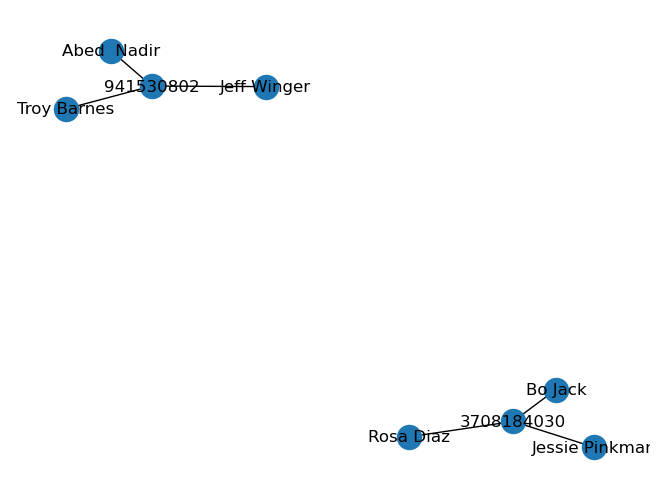

In [16]:
show_graph(G)
# Here we can see that Annie is in two papers, however none of her collaborators repeat

In [17]:
y = searchAuthorPapers(_df, authorList[3]) # This is the dictionary for Rosa Diaz

In [18]:
G2 = create_graph(y)

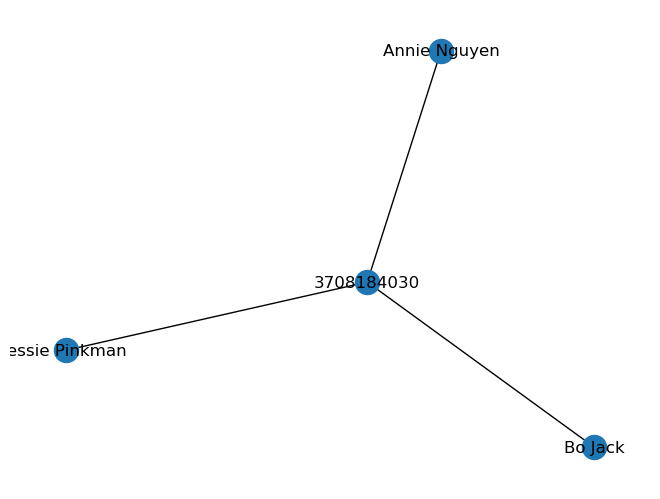

In [19]:
show_graph(G2) # Here you can see she is part of the one paper with Annie, and no other papers

In [20]:
annie_index = calculateDIndex(authorList[2], x, G)

pub.941530802
Gender Factor: 3
Nationality Factor: 6
pub.3708184030
Gender Factor: 2
Nationality Factor: 2


In [23]:
print(authorList[2].getName() + "'s D-Index: "+ str(annie_index))

Annie Nguyen's D-Index: 6


In [24]:
rosa_index = calculateDIndex(authorList[3], y, G2)

pub.3708184030
Gender Factor: 2
Nationality Factor: 2


In [25]:
print(authorList[3].getName() + "'s D-Index: "+ str(rosa_index))

Rosa Diaz's D-Index: 4


In [26]:
show_author_publications(x, G)

pub.941530802
Author: Abed  Nadir from Jerusalem, Palestine(male)
Number of shared occurences: 1
Author: Troy Barnes from Atlanta, United States(male)
Number of shared occurences: 1
Author: Jeff Winger from Rome, Italy(male)
Number of shared occurences: 1

pub.3708184030
Author: Bo Jack from Toronto, Canada(male)
Number of shared occurences: 1
Author: Jessie Pinkman from Emmett, United States(male)
Number of shared occurences: 1
Author: Rosa Diaz from Houston, United States(female)
Number of shared occurences: 1



In [27]:
show_author_publications(y, G2)

pub.3708184030
Author: Bo Jack from Toronto, Canada(male)
Number of shared occurences: 1
Author: Jessie Pinkman from Emmett, United States(male)
Number of shared occurences: 1
Author: Annie Nguyen from Los Angeles, United States(female)
Number of shared occurences: 1



### Example 2
This example shows how authors of the same paper can have different indexes just based on their perspective within the paper
All of these authors are only linked to this paper.
Due to the fact there is one female from a foreign country her perspective needs to be multiplied greatly to achieve equal representation. 
On the other hand, three of four authors are males from the US, therefore their perspectives are considered similar.

In [28]:
authorList = collectAuthorsOfOnePaper(_df, "pub.1156792011")

In [29]:
for author in authorList:
    author.display()

Author: Kelly Kapoor from Bangalore, India(female)
Author: Michael Scott from Scranton, United States(male)
Author: Jim Halpert from Scranton, United States(male)
Author: Dwight  Schrute from Scranton, United States(male)


In [30]:
x = searchAuthorPapers(_df, authorList[0])

In [31]:
G = create_graph(x)

In [32]:
index = calculateDIndex(authorList[0], x, G)

pub.1156792011
Gender Factor: 3
Nationality Factor: 8


In [33]:
print(index)

11


In [34]:
y = searchAuthorPapers(_df, authorList[1])

In [35]:
G2 = create_graph(y)

In [36]:
index2 = calculateDIndex(authorList[1], y, G2)

pub.1156792011
Gender Factor: 1
Nationality Factor: 2


In [37]:
print(index2)

3


### Example 3

This example explores the relationship of one author who has collaborated with other authors across three papers. This will represent the cross-paper feature of number of shared occurences.

You can see the D-index of the author drops 4 points by 

In [38]:
# Compile list of authors from selected publication
authorList = collectAuthorsOfOnePaper(_df, "pub.1123345821", start_point=0) 

In [39]:
for author in authorList: 
    author.display()

Author: Jake Peralta from Rome, Italy(male)
Author: Amy Santiago from Havana, Cuba(female)
Author: Ray Holt from New York City, United States(male)
Author: Rosa  Diaz from Mexico City, Mexico(female)
Author: Charles Boyle from New York City, United States(male)
Author: Gina Linetti from New York City, United States(female)


In [40]:
# Creates dictionary of people Jake Peralta has worked with across all of the papers he is in in the dataframe
x = searchAuthorPapers(_df, authorList[0]) 

In [41]:
G = create_graph(x) # creates Graph from dictionary

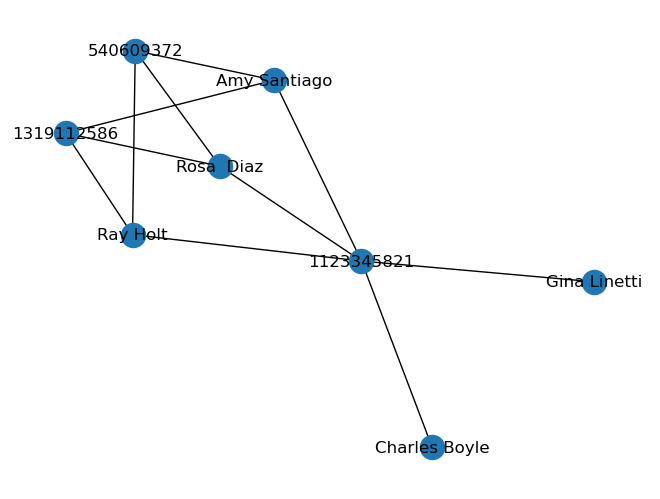

In [44]:
# As you can see, there is a group of authors that appear to have shared appearances in three papers, 
# along with two outliers added in a third paper
show_graph(G)

In [45]:
index = calculateDIndex(authorList[0], x, G, minRepeats=2) # Calculate index for Jake 

pub.1123345821
Gender Factor: 2
Nationality Factor: 20
pub.1319112586
Gender Factor: 2
Nationality Factor: 12
pub.540609372
Gender Factor: 2
Nationality Factor: 12


In [46]:
print(authorList[0].getName() + "'s D-Index: "+ str(index))

Jake Peralta's D-Index: 17


In [47]:
show_author_publications(x, G) # Use to fact-check the math

pub.1123345821
Author: Amy Santiago from Havana, Cuba(female)
Number of shared occurences: 3
Author: Ray Holt from New York City, United States(male)
Number of shared occurences: 3
Author: Rosa  Diaz from Mexico City, Mexico(female)
Number of shared occurences: 3
Author: Charles Boyle from New York City, United States(male)
Number of shared occurences: 1
Author: Gina Linetti from New York City, United States(female)
Number of shared occurences: 1

pub.1319112586
Author: Amy Santiago from Havana, Cuba(female)
Number of shared occurences: 3
Author: Ray Holt from New York City, United States(male)
Number of shared occurences: 3
Author: Rosa  Diaz from Mexico City, Mexico(female)
Number of shared occurences: 3

pub.540609372
Author: Amy Santiago from Havana, Cuba(female)
Number of shared occurences: 3
Author: Ray Holt from New York City, United States(male)
Number of shared occurences: 3
Author: Rosa  Diaz from Mexico City, Mexico(female)
Number of shared occurences: 3



In [48]:
# Calculate index without decreasing the authors added value for repeat occurences
index = calculateDIndex(authorList[0], x, G, minRepeats=2, crossPaper=False) 

pub.1123345821
Gender Factor: 2
Nationality Factor: 24
pub.1319112586
Gender Factor: 2
Nationality Factor: 16
pub.540609372
Gender Factor: 2
Nationality Factor: 16


In [49]:
print(authorList[0].getName() + "'s D-Index without crossPaperFeatures: "+ str(index))

Jake Peralta's D-Index without crossPaperFeatures: 21
